In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statistics as st
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Decision Tree

In [ ]:
X,y = load_breast_cancer(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .25, random_state = 345)

In [ ]:
class Node:
  def __init__(self, feature = None, threshold = None, left = None, right = None,*, value = None): # make value a keyword argument
    self.feature = feature
    self.threshold = threshold
    self.left = left
    self.right = right
    self.value = value

  def is_leaf(self):
    return self.value is not None

In [ ]:
class Impurity:
  def __init__(self, impurity):
    self.impurity = impurity

  def calculate(self,y):
    raise NotImplementedError("Subclass must implement calculate")

class Gini(Impurity):
  def __init__(self):
    super().__init__("gini")

  def calculate(self, y):
    p = np.bincount(y)
    p = p/len(y)
    return 1 - np.sum(np.fromiter((pk**2 for pk in p), float))

class Entropy(Impurity):
  def __init__(self):
    super().__init__("entropy")

  def calculate(self,y):
    p = np.bincount(y)
    p = p/len(y)
    return -np.sum(np.fromiter((pk * np.log(pk) for pk in p if pk>0),float) )

In [ ]:
class DecisionTree:
  def __init__(self,impurity = "gini",  max_tree_depth = 100, min_sample_leaf = 2, n_features = None , max_leaf = None):
    self.max_tree_depth = max_tree_depth
    self.min_sample_leaf = min_sample_leaf
    self.n_features = n_features # no of features to consider while calculating the best split
    self.max_leaf = max_leaf
    self.leaf_count = 0
    self.impurity_measure = None

    if impurity == "gini":
      self.impurity_measure = Gini()
    elif impurity == "entropy":
      self.impurity_measure = Entropy()
    else:
      raise ValueError("Invalid impurity type impurity must belong to [gini,entropy]")

  def fit(self, X, y):
    self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features) # if n_features is none then n_features will be all the features of X
    self.root = self._make_tree(X,y)

  def _make_tree(self,X,y, depth = 0):
    n_sample , n_feats = X.shape
    n_classes = len(np.unique(y))

    if (depth >= self.max_tree_depth or n_classes == 1 or n_sample< self.min_sample_leaf):
      leaf_value = self._most_common_class(y)
      return Node(value = leaf_value)

    n_idx = np.random.choice(n_feats, self.n_features, replace = False) # this will find unique value of index with no repetitions hence all chosen features will be unique

    best_feat , best_threshold = self._best_split(X,y, n_idx)

    left, right = self._split(X[:, best_feat],best_threshold)
    left = self._make_tree(X[left], y[left], depth+1)
    right = self._make_tree(X[right], y[right], depth+1)

    return Node(best_feat, best_threshold, left, right)

  def _most_common_class(self,y):
    return st.mode(y)

  def _best_split(self, X,y, n_idx):
    best_gain = -1
    split_idx, split_threshold = None, None

    for i in n_idx:
      threshold = np.unique(X[:,i])

      for thr in threshold:
        gain = self._info_gain(X,y,thr,i)

        if gain > best_gain:
          best_gain = gain
          split_idx = i
          split_threshold = thr

    return split_idx, split_threshold

  def _info_gain(self, X,y, threshold, idx):
    #parent entropy
    e_p = self.impurity_measure.calculate(y)

    #children entropy
    left, right = self._split(X[:,idx],threshold)
    s = len(y)
    s_l, s_r = len(left),  len(right)
    e_l, e_r = self.impurity_measure.calculate(y[left]) , self.impurity_measure.calculate(y[right])

    e_ch = s_l/s * e_l + s_r/s * e_r

    #info gain calculation
    return e_p - e_ch

  def _split(self, X_split_feat ,threshold):
    right_idx = np.argwhere(X_split_feat> threshold).flatten()
    left_idx = np.argwhere(X_split_feat <= threshold).flatten()
    return left_idx , right_idx

  def predict(self,X_test):
    return np.array([self._traverse(x,self.root) for x in X_test])

  def _traverse(self, x, node):
    if node.is_leaf():
      return node.value

    if (x[node.feature] <= node.threshold):
      return self._traverse(x, node.left)
    return self._traverse(x, node.right)






In [ ]:
md = DecisionTree(impurity = "entropy", n_features = 10)
md.fit(X_train , y_train)
y_pred = md.predict(X_test)
print(f1_score(y_test, y_pred))

0.9425287356321839


0.9195402298850575


[Text(0.5955056179775281, 0.95, 'x[22] <= 113.15\ngini = 0.465\nsamples = 426\nvalue = [157, 269]'),
 Text(0.4157303370786517, 0.85, 'x[27] <= 0.146\ngini = 0.147\nsamples = 287\nvalue = [23, 264]'),
 Text(0.5056179775280899, 0.8999999999999999, 'True  '),
 Text(0.3258426966292135, 0.75, 'x[23] <= 929.8\ngini = 0.051\nsamples = 266\nvalue = [7, 259]'),
 Text(0.2808988764044944, 0.65, 'x[28] <= 0.161\ngini = 0.044\nsamples = 265\nvalue = [6, 259]'),
 Text(0.23595505617977527, 0.55, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.3258426966292135, 0.55, 'x[6] <= 0.12\ngini = 0.037\nsamples = 264\nvalue = [5, 259]'),
 Text(0.20224719101123595, 0.45, 'x[14] <= 0.003\ngini = 0.023\nsamples = 257\nvalue = [3, 254]'),
 Text(0.0898876404494382, 0.35, 'x[21] <= 27.755\ngini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.0449438202247191, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.1348314606741573, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.3146067415730337, 0.

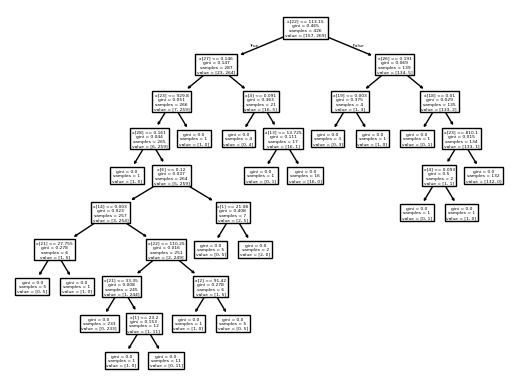

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(f1_score(y_test, y_pred))
plot_tree(dt)

#Random Forest


In [ ]:
X,y = load_breast_cancer(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .25, random_state = 345)
# sample = random.sample(range(0,X_train.shape[0]),100)
# print(sample)

In [ ]:
class RandomForest:
  def __init__(self, estimators = 10 ,n_samples = .5,bt_features = None, max_depth = None, min_sample_leaf = None, n_features = None , max_leaf = None):
    self.estimators = estimators
    self.n_samples = n_samples
    self.bt_features = bt_features
    self.max_depth = max_depth
    self.min_sample_leaf = min_sample_leaf
    self.n_features = n_features
    self.max_leaf = max_leaf
    self.trees = []

  def fit(self, X_train, y_train):

    self.trees = []

    for _ in range(self.estimators):
      tree = DecisionTree(impurity = "gini",  max_tree_depth = self.max_depth, min_sample_leaf = self.min_sample_leaf , n_features = self.n_features , max_leaf = self.max_leaf)
      X_sample, y_sample = self.bootstrap(X_train,y_train)
      tree.fit(X_sample, y_sample)
      self.trees.append(tree)

  def bootstrap(self, X,y):
    idx_ft = []
    idx = np.random.choice(range(0, X.shape[0]),int(X.shape[0]*self.n_samples), replace = True)
    if (self.bt_features is not None):
      idx_ft = np.random.choice(range(0, X.shape[1]),int(X.shape[1]*self.bt_features), replace = True)

    X_sample , y_sample = X[idx], y[idx]
    if (self.bt_features is not None):
      X_sample = X_sample[:,idx_ft]

    return X_sample,y_sample

  def most_common_prediction(self,y):
    count = Counter(y)
    most_common = count.most_common(1)[0][0]
    return most_common


  def predict(self, X_test):
    y_pred = []
    predictions = np.array([])
    for tree in self.trees:
      y_pred.append(tree.predict(X_test))
    y_pred = np.array(y_pred).T
    for y in y_pred:
        predictions = np.append(predictions, self.most_common_prediction(y))

    return predictions


In [ ]:
md = RandomForest(estimators = 10, max_depth = 4, min_sample_leaf = 2, max_leaf = 100, n_samples = .5, n_features = 2)
md.fit(X_train, y_train)
y_pred = md.predict(X_test)
print(y_pred)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

[0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.]
0.916083916083916
0.9310344827586207
